In [1]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import os
import datetime

#Plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
maindir = "C:\\Users\\afajardo\\Desktop\\Projects\\Kaggle\\Zillow"

## Reading in the Data 

In [3]:
logerror = pd.read_csv(maindir + "\\data\\train_2016_v2.csv\\train_2016_v2.csv")
logerror['weeknumber'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').isocalendar()[1])
logerror['month'] = logerror['transactiondate'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d').month)

properties = pd.read_csv(maindir + "\\data\\properties_2016.csv\\properties_2016.csv")
test_parcels = pd.read_csv(maindir + "\\data\\sample_submission.csv", usecols = ['ParcelId'])
test_parcels.rename(columns={'ParcelId':'parcelid'}, inplace=True)

# join on parcel id
data = pd.merge(properties,logerror[['parcelid','logerror','month']], on='parcelid')

C:\Users\afajardo\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
logerror.parcelid.nunique()

90150

In [5]:
properties.parcelid.nunique()

2985217

In [6]:
properties.shape

(2985217, 58)

In [7]:
assert test_parcels.shape[0] == test_parcels.parcelid.nunique()
test_parcels.parcelid.nunique()

2985217

In [8]:
data.parcelid.nunique()

90150

In [9]:
logerror['transactiondate'].max()

'2016-12-30'

In [10]:
logerror.groupby('month')['logerror'].agg({np.size, np.mean})

,size,mean
month,,
1,6556,0.015870
2,6333,0.016082
3,8652,0.009867
4,9311,0.006605
5,9961,0.006926
6,10922,0.007172
7,9947,0.011687
8,10476,0.011573
9,9575,0.016255


### Plotting log errors per week

In [11]:
logerror.head()

,parcelid,logerror,transactiondate,weeknumber,month
0,11016594,0.0276,2016-01-01,53,1
1,14366692,-0.1684,2016-01-01,53,1
2,12098116,-0.0040,2016-01-01,53,1
3,12643413,0.0218,2016-01-02,53,1
4,14432541,-0.0050,2016-01-02,53,1


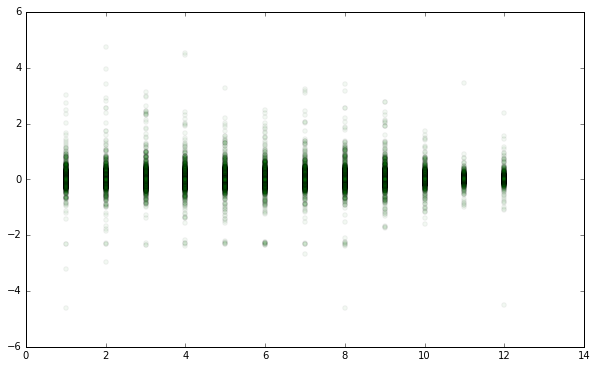

In [12]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='white')
ax.set_axis_bgcolor('white')
ax.scatter(logerror['month'],logerror['logerror'], alpha=0.05, c='green')

## Data Preprocessing

In [13]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, Imputer 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# A custom transformer, which selects certain variables
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, desired_cols):
        self.desired_cols = desired_cols
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.desired_cols].values

# A custom transformer, which first selects the categorical variables
# from the DataFrame and then performs the dummification
class DF_Selector_GetDummies(BaseEstimator, TransformerMixin):
    def __init__(self, cat_dict):
        self.cat_dict = cat_dict
        self.ndummies = sum(len(c) - 1  for c in cat_dict.values()) 
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.fillna(-1) # missing values are given -1 missing label
        foo = np.zeros((X.shape[0],self.ndummies))
        start = 0
        end = 0
        for c in sorted(self.cat_dict.keys()):
            end += len(self.cat_dict[c]) - 1
            foo[:, start:end] = pd.get_dummies(X[c].astype('category', categories=self.cat_dict[c]))[self.cat_dict[c][1:]]
            start += len(self.cat_dict[c]) - 1
        return foo

In [14]:
# Setup variables considered in the model

# numerical variables
num_atts = ['bathroomcnt','bedroomcnt','buildingqualitytypeid','calculatedbathnbr','finishedfloor1squarefeet',
           'calculatedfinishedsquarefeet','finishedsquarefeet12','finishedsquarefeet13',
           'finishedsquarefeet15','finishedsquarefeet50','finishedsquarefeet6','fireplacecnt',
           'fullbathcnt','garagecarcnt','garagetotalsqft','latitude','longitude','lotsizesquarefeet',
           'poolcnt','poolsizesum','censustractandblock','roomcnt','threequarterbathnbr','unitcnt',
           'yardbuildingsqft17','yardbuildingsqft26','numberofstories',
            'structuretaxvaluedollarcnt','taxvaluedollarcnt','landtaxvaluedollarcnt','taxamount']

# categorical varaibles
cat_atts = ['airconditioningtypeid','architecturalstyletypeid',
           'buildingclasstypeid','heatingorsystemtypeid','pooltypeid10','pooltypeid2',
            'pooltypeid7','propertylandusetypeid','regionidcounty',
           'storytypeid','typeconstructiontypeid','yearbuilt','fireplaceflag',
           'taxdelinquencyflag']

# Dictionary of categorical variables and their default levels
cat_dict = {'airconditioningtypeid':[-1] + list(range(1,14)),
           'architecturalstyletypeid':[-1] + list(range(1,28)),
           'buildingclasstypeid':[-1] + list(range(1,6)),
            'heatingorsystemtypeid':[-1] + list(range(1,26)),
            'pooltypeid10': list(range(-1,2)),
            'pooltypeid2': list(range(-1,2)),
            'pooltypeid7': list(range(-1,2)),
            'propertylandusetypeid': [-1, 31,46,47,246,247,248,260,261,262,263,264,265,266,267,268,269,270,271,
                                     273,274,275,276,279,290,291],
            'regionidcounty': [2061,3101,1286],
            'storytypeid':[-1] + list(range(1,36)),
            'typeconstructiontypeid':[-1] + list(range(1,19)),
            'yearbuilt': [-1] + list(range(1885,2018)),
            'fireplaceflag': [-1] + ['True','False'],
            'taxdelinquencyflag': [-1] + ['Y','N']
           }

### Data Preprocessing Pipeline 

In [15]:
# Categorical pipeline
cat_pipeline = Pipeline([
        ('select_and_dummify', DF_Selector_GetDummies(cat_dict)),
        ('scaler', StandardScaler()),
    ])

# Numerical pipeline
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_atts)),
        ('imputer', Imputer()),
        ('scaler', StandardScaler()),
    ])

# Full pipeline
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])

## Training a Random Forest

In [16]:
from sklearn.model_selection import train_test_split

### Creating a training and test set

In [17]:
traindata, testdata = train_test_split(data, test_size = 0.2, random_state=9)
traindata = traindata.reset_index(drop=True)
testdata = testdata.reset_index(drop=True)

In [18]:
traindata.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,month
0,11583759,NaN,NaN,NaN,2.0,2,NaN,4,2.0,NaN,...,148780,420949,2015,272169,5264.12,NaN,NaN,6.037702e+13,-0.0060,2
1,11186265,1,NaN,NaN,3.0,4,NaN,4,3.0,NaN,...,220496,275619,2015,55123,4784.18,NaN,NaN,6.037910e+13,0.0030,7
2,11267435,1,NaN,NaN,2.0,3,NaN,4,2.0,NaN,...,133199,177667,2015,44468,3055.39,NaN,NaN,6.037901e+13,0.3784,10
3,14481196,NaN,NaN,NaN,3.5,4,NaN,NaN,3.5,NaN,...,516586,1084952,2015,568366,11282.22,NaN,NaN,6.059032e+13,-0.1031,2
4,12159764,NaN,NaN,NaN,2.0,3,NaN,7,2.0,NaN,...,61716,139677,2015,77961,2057.55,NaN,NaN,6.037461e+13,0.1823,4


In [19]:
# Use preprocessing pipe line to prepare features data
train_feats = full_pipeline.fit_transform(traindata)
test_feats = full_pipeline.transform(testdata)

### Random Forests

In [20]:
from sklearn.ensemble import RandomForestRegressor

In [21]:
regr_rf = RandomForestRegressor(n_estimators = 100, max_features = 5, random_state=2, max_depth=35, criterion='mse')

In [22]:
regr_rf.fit(train_feats, traindata['logerror'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
           max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [23]:
# training RSq
regr_rf.score(train_feats, traindata['logerror'])

0.34618515421608037

### Test data Performance

In [24]:
predictions = regr_rf.predict(test_feats)

In [25]:
absolute_error = abs(predictions - testdata['logerror'])
testdata['absolute_error'] = absolute_error

In [26]:
p75 = absolute_error.describe().ix['75%']
absolute_error.describe()

count    1.805500e+04
mean     6.928781e-02
std      1.526828e-01
min      8.448892e-07
25%      1.420246e-02
50%      3.272428e-02
75%      6.907613e-02
max      4.619767e+00
Name: logerror, dtype: float64

In [27]:
# querying absolute_errors that are less than the 75-th percentile
ngood = int((absolute_error[absolute_error <= p75]).describe().ix['count'])
(absolute_error[absolute_error <= p75]).describe()

count    1.354100e+04
mean     2.602836e-02
std      1.839631e-02
min      8.448892e-07
25%      1.060143e-02
50%      2.266385e-02
75%      3.911822e-02
max      6.907610e-02
Name: logerror, dtype: float64

In [28]:
# querying absolute_errors that are greater than the 75-th percentile
nbad = int((absolute_error[absolute_error > p75]).describe().ix['count'])
(absolute_error[absolute_error > p75]).describe()

count    4514.000000
mean        0.199057
std         0.264168
min         0.069076
25%         0.088727
50%         0.120870
75%         0.201591
max         4.619767
Name: logerror, dtype: float64

### Plotting the log-errors 

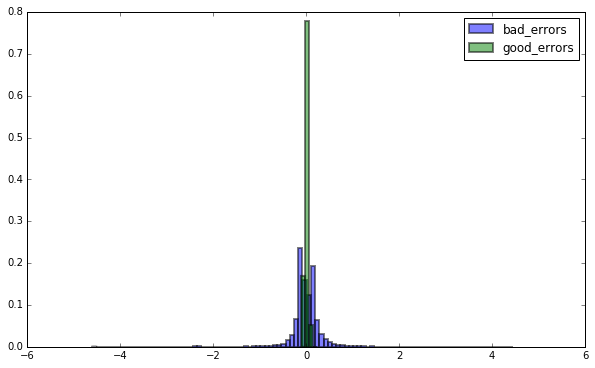

In [29]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='white')
ax.set_axis_bgcolor('white')
ax.hist(testdata[absolute_error > p75]['logerror'].values, alpha=0.5, lw=2, weights = np.ones(nbad) / nbad, bins = 100)
ax.hist(testdata[absolute_error <= p75]['logerror'].values, alpha=0.5, lw=2, weights = np.ones(ngood) / ngood,
       bins = 4)
plt.legend(['bad_errors','good_errors'])
plt.show()

### Plotting prediction vs actuals 

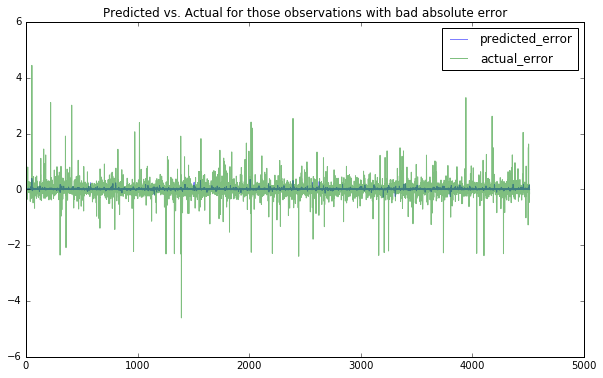

In [30]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='white')
ax.set_axis_bgcolor('white')
ax.plot(regr_rf.predict(test_feats)[np.where(absolute_error > p75)], alpha=0.5)
ax.plot(testdata['logerror'].values[np.where(absolute_error > p75)], alpha=0.5)
plt.legend(['predicted_error','actual_error'])
plt.title("Predicted vs. Actual for those observations with bad absolute error")

In [31]:
print("Summary descriptions of predictions")
print(Series(regr_rf.predict(test_feats)[np.where(absolute_error > p75)]).describe())
print()
print("Summary descriptions of actual logerrors")
print(Series(testdata['logerror'].values[np.where(absolute_error > p75)]).describe())

Summary descriptions of predictions
count    4514.000000
mean        0.013844
std         0.027360
min        -0.277353
25%         0.005230
50%         0.010941
75%         0.018804
max         0.392855
dtype: float64

Summary descriptions of actual logerrors
count    4514.000000
mean        0.013562
std         0.333120
min        -4.605000
25%        -0.109800
50%        -0.051300
75%         0.131900
max         4.445000
dtype: float64


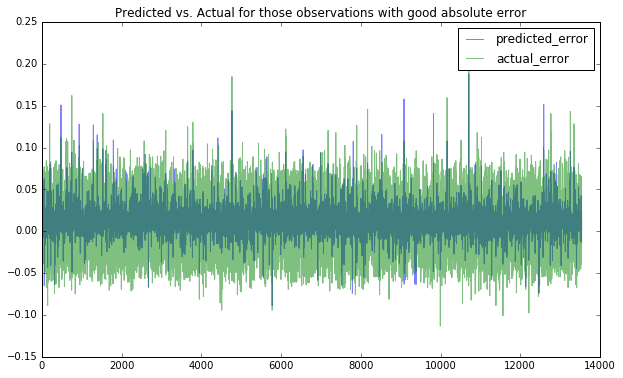

In [32]:
fig, ax = plt.subplots(figsize=(10,6), facecolor='white', edgecolor='white')
ax.set_axis_bgcolor('white')
ax.plot(regr_rf.predict(test_feats)[np.where(absolute_error <= p75)], alpha=0.5)
ax.plot(testdata['logerror'].values[np.where(absolute_error <= p75)], alpha=0.5)
plt.legend(['predicted_error','actual_error'])
plt.title("Predicted vs. Actual for those observations with good absolute error")
plt.show()

In [33]:
print("Summary descriptions of predictions")
print(Series(regr_rf.predict(test_feats)[np.where(absolute_error <= p75)]).describe())
print()
print("Summary descriptions of actual logerrors")
print(Series(testdata['logerror'].values[np.where(absolute_error <= p75)]).describe())

Summary descriptions of predictions
count    13541.000000
mean         0.011562
std          0.012401
min         -0.088938
25%          0.006251
50%          0.010470
75%          0.015749
max          0.187741
dtype: float64

Summary descriptions of actual logerrors
count    13541.000000
mean         0.007840
std          0.032868
min         -0.113200
25%         -0.014100
50%          0.006000
75%          0.029600
max          0.242900
dtype: float64


### Things to consider

In [34]:
# how to impute missing data? (currenly using mean values for numerical attributes)
# how to actually produce 6 predictions based on time
# interaction with counties?
# feature selection/engineering (i.e., transformations)
# whatsup with the 4514 observations in the test set... why are the log-errors so crazy
# whatsup with county 3101?

## Elastic Net

In [35]:
from sklearn.linear_model import ElasticNet

In [36]:
# Picking any old values for the hyperparameters
elastic_net = ElasticNet(alpha=1, l1_ratio = 0, max_iter=1000)

In [37]:
elastic_net.fit(train_feats, traindata['logerror'])

C:\Users\afajardo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
C:\Users\afajardo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
elastic_net_preds = elastic_net.predict(test_feats)

In [39]:
elastic_net_absolute_error = abs(elastic_net_preds - testdata['logerror'])
elastic_net_absolute_error.describe()

count    18055.000000
mean         0.069170
std          0.153971
min          0.000002
25%          0.014438
50%          0.032430
75%          0.068511
max          4.610288
Name: logerror, dtype: float64

## SVM Regression

In [46]:
from sklearn.svm import SVR

In [47]:
svm_poly_reg = SVR(kernel="rbf", C=0.01, epsilon=0.1, max_iter=1000)

In [48]:
svm_poly_reg.fit(train_feats, traindata['logerror'])

C:\Users\afajardo\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\svm\base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVR(C=0.01, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=1000, shrinking=True, tol=0.001, verbose=False)

In [49]:
svm_preds = svm_poly_reg.predict(test_feats)
svm_preds

array([-0.3265598 , -0.34253417, -0.35113058, ..., -0.26488053,
       -0.3373295 , -0.30429062])

In [50]:
svm_absolute_error = abs(svm_preds - testdata['logerror'])
svm_absolute_error.mean()

0.3354684855525604

# Predicting 2016 errors

In [155]:
def generate_submissions(oct_model,nov_model,dec_model,name='new_submission',logy=True):
    """
    This function creates the submission file for the public leaderboard predictions.
    Three already fitted models, one for each of the predicting time points, is required.
    """
    submission_df = DataFrame()
    for i in range(int(properties.shape[0] / 100000)):
        all_feats = full_pipeline.transform(properties.ix[i*100000:(i+1)*100000])
        foo = properties.ix[i*100000:(i+1)*100000][['parcelid']].reset_index(drop=True)
        if logy:
            foo = pd.concat([foo, DataFrame({'201610': oct_model.predict(all_feats),
                                                            '201611': nov_model.predict(all_feats),
                                                            '201612': dec_model.predict(all_feats)})], axis=1)
        else:
            foo = pd.concat([foo, DataFrame({'201610': np.log(oct_model.predict(all_feats)),
                                                            '201611': np.log(nov_model.predict(all_feats)),
                                                            '201612': np.log(dec_model.predict(all_feats))})], axis=1)
        submission_df = pd.concat([submission_df, foo], ignore_index=True)

    #  fencepost problem
    all_feats = full_pipeline.transform(properties.ix[2900000:])
    foo = properties.ix[2900000:][['parcelid']].reset_index(drop=True)
    foo = pd.concat([foo, DataFrame({'201610': oct_model.predict(all_feats),
                                                    '201611': nov_model.predict(all_feats),
                                                    '201612': dec_model.predict(all_feats)})], axis=1)
    submission_df = pd.concat([submission_df, foo], ignore_index=True)
    
    submission_df['201710'] = 0
    submission_df['201711'] = 0
    submission_df['201712'] = 0
    
    submission_df.drop_duplicates(inplace=True)
    submission_df.rename(columns={'parcelid':'ParcelId'}, inplace=True)
    assert submission_df.shape[0] == properties.shape[0]
    submission_df[['201610','201611','201612','201710','201711','201712']]= submission_df[['201610','201611','201612',
                                                                                           '201710','201711','201712']].round(4)
    submission_df[['ParcelId','201610','201611','201612',
                  '201710','201711','201712']].to_csv(name + ".csv", index=False)
    return submission_df

## 3+1-month rolling models

Objective: building a model for each month of interest: October, November, December.

Method: Train three different models using three different but mostly overlapping datasets. The training data for month x represents all of the observations occurring in month x and up to the 3 months before x. For example, for the October model, we will train the data using July-October.

In [132]:
oct_cond = data['month'].isin([1,2,3,4,5,6,7,8,9,10])
nov_cond = data['month'].isin([1,2,3,4,5,6,7,8,9,10,11])
dec_cond = data['month'].isin([1,2,3,2,5,6,7,8,9,10,11,12])

In [133]:
oct_feats = full_pipeline.transform(data[oct_cond])
nov_feats = full_pipeline.transform(data[nov_cond])
dec_feats = full_pipeline.transform(data[dec_cond])

In [119]:
oct_regr_rf = RandomForestRegressor(n_estimators = 100, max_features = 5, random_state=2, max_depth=35, criterion='mse')
nov_regr_rf = RandomForestRegressor(n_estimators = 100, max_features = 5, random_state=2, max_depth=35, criterion='mse')
dec_regr_rf = RandomForestRegressor(n_estimators = 100, max_features = 5, random_state=2, max_depth=35, criterion='mse')

oct_regr_rf.fit(oct_feats,data[oct_cond]['logerror'])
nov_regr_rf.fit(nov_feats,data[nov_cond]['logerror'])
dec_regr_rf.fit(dec_feats,data[dec_cond]['logerror'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
           max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [120]:
submission_df = generate_submissions(oct_regr_rf, nov_regr_rf, dec_regr_rf)

## Sample-Weighted Models

#### Basic sample weights

In [109]:
data['wts_oct'] = np.where(data['month'] == 10, 2, 1)
data['wts_nov'] = np.where(data['month'] == 11, 2, 1)
data['wts_dec'] = np.where(data['month'] == 12, 2, 1)

In [110]:
oct_regr_rf = RandomForestRegressor(n_estimators = 100, max_features = 5, random_state=2, max_depth=35, criterion='mse')
nov_regr_rf = RandomForestRegressor(n_estimators = 100, max_features = 5, random_state=2, max_depth=35, criterion='mse')
dec_regr_rf = RandomForestRegressor(n_estimators = 100, max_features = 5, random_state=2, max_depth=35, criterion='mse')

In [111]:
feats = full_pipeline.fit_transform(data)

In [112]:
oct_regr_rf.fit(feats,data['logerror'], sample_weight=data['wts_oct'])
nov_regr_rf.fit(feats,data['logerror'], sample_weight=data['wts_nov'])
dec_regr_rf.fit(feats,data['logerror'], sample_weight=data['wts_dec'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
           max_features=5, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [ ]:
submission_df = generate_submissions(oct_regr_rf, nov_regr_rf, dec_regr_rf)

## Neural Nets

In [121]:
from sklearn.neural_network import MLPRegressor

In [122]:
feats.shape

(90275, 324)

In [134]:
neural_net = MLPRegressor(hidden_layer_sizes=(250,200), learning_rate_init=0.25, random_state=9)

In [135]:
neural_net.fit(feats, data['logerror'])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(250, 200), learning_rate='constant',
       learning_rate_init=0.25, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=9, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [136]:
abs(neural_net.predict(feats) - data['logerror']).mean()

0.06841550417074954

### Rolling model neural nets

In [154]:
# train on exp(log(relative_error))

oct_nn = MLPRegressor(hidden_layer_sizes=(250,200), learning_rate_init=0.25, learning_rate='adaptive',
                      random_state=9, early_stopping=True, max_iter = 1000)
nov_nn = MLPRegressor(hidden_layer_sizes=(250,200), learning_rate_init=0.25, learning_rate='adaptive',
                      random_state=9, early_stopping=True, max_iter = 1000)
dec_nn = MLPRegressor(hidden_layer_sizes=(250,200), learning_rate_init=0.25, learning_rate='adaptive',
                      random_state=9, early_stopping=True, max_iter = 1000)

oct_nn.fit(oct_feats,data[oct_cond]['logerror'])
nov_nn.fit(nov_feats,data[nov_cond]['logerror'])
dec_nn.fit(dec_feats,data[dec_cond]['logerror'])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(250, 200), learning_rate='adaptive',
       learning_rate_init=0.25, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=9, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [ ]:
submission_df = generate_submissions(oct_nn, nov_nn, dec_nn,name="submision_12", logy=False)